In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/admyyh/miniconda3/envs/ultralytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data loading
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [4]:
# AAE Model
class AAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=32):
        super(AAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x_flat = x.view(-1, 784)
        z = self.encoder(x_flat)
        x_recon = self.decoder(z)
        return x_recon, z

In [5]:
# Loss functions
def aae_loss(recon_x, x, z, discriminator, lambda_adv=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view(-1, 784))
    
    # Adversarial loss
    real_z = torch.randn_like(z)  # Sample from prior N(0, I)
    real_pred = discriminator(real_z)
    fake_pred = discriminator(z)
    
    disc_loss = -torch.mean(torch.log(real_pred + 1e-8) + torch.log(1 - fake_pred + 1e-8))
    gen_loss = -torch.mean(torch.log(fake_pred + 1e-8))
    
    return recon_loss + lambda_adv * gen_loss, disc_loss, recon_loss

In [6]:
model = AAE().to(device)

In [7]:
# Training
optimizer_ae = optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=1e-5)
optimizer_disc = optim.Adam(model.discriminator.parameters(), lr=1e-5)

for epoch in range(1, 11):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        
        # Update AE (reconstruction + generator)
        optimizer_ae.zero_grad()
        recon_batch, z = model(data)
        loss, disc_loss, recon_loss = aae_loss(recon_batch, data, z, model.discriminator)
        loss.backward()
        optimizer_ae.step()
        
        # Update discriminator
        optimizer_disc.zero_grad()
        recon_batch, z = model(data)
        _, disc_loss, _ = aae_loss(recon_batch, data, z, model.discriminator)
        disc_loss.backward()
        optimizer_disc.step()
        
        train_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {train_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.9242
Epoch 2, Loss: 0.8944
Epoch 3, Loss: 0.8575
Epoch 4, Loss: 0.8212
Epoch 5, Loss: 0.7927
Epoch 6, Loss: 0.7696
Epoch 7, Loss: 0.7487
Epoch 8, Loss: 0.7353
Epoch 9, Loss: 0.7340
Epoch 10, Loss: 0.7431


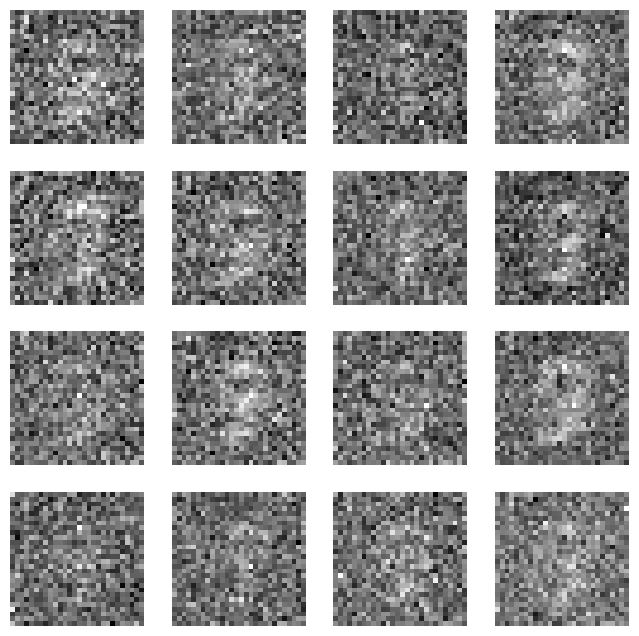

In [9]:
# Generation
model.eval()
with torch.no_grad():
    z = torch.randn(16, 32, device=device)  # Sample from N(0, I)
    generated = model.decoder(z).cpu().view(-1, 28, 28)

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i], cmap='gray')
    ax.axis('off')
plt.show()